Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513 - Introdução ao Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$


# Exercício 9: Detecção de Anomalias e Sistemas de Recomendação

Neste exercício, você irá explorar duas aplicações de técnicas de aprendizado de máquina: estimação de densidade para detecção de anomalias, um problema de aprendizado não supervisionado; e um algoritmo de fatoração matricial para filtragem colaborativa em um sistema de recomendação.

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import multivariate_normal

def plot_data(X, outliers=None, mean=None, cov=None):
    plt.scatter(X[:,0], X[:,1], marker='x')
    plt.axis('square')
    plt.axis([0, 30, 0, 30])
    plt.gcf().set_size_inches(5, 5)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (Mbit/s)');
    # circle outliers
    if outliers is not None:
        outliers = outliers > 0
        plt.scatter(X[outliers,0], X[outliers,1], c='none', marker='o', 
                    edgecolors='red', linewidths=2, s=100)
    # plot level curves corresponding to p = 10^-3, 10^-6, 10^-9, ...
    if mean is not None and cov is not None:
        X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
        XX = np.c_[X1.reshape(-1), X2.reshape(-1)]
        p = multivariate_normal(mean=mean, cov=cov).pdf(XX)
        p = p.reshape(X1.shape)
        plt.contour(X1, X2, -np.log10(p + np.finfo(np.float64).tiny), 
                    levels=3*np.arange(1, 11), cmap=plt.cm.Greens_r, zorder=-1)
    plt.show()

# Detecção de anomalias

## Conjunto de dados #1

O primeiro conjunto de dados possui como atributos o _throughput_ (Mbit/s) e a latência (ms) da resposta de cada servidor de uma rede, medidos em vários momentos durante seu funcionamento. O objetivo é detectar um comportamento anômalo. Você dispõe de um conjunto de treinamento não-rotulado $\bX$ e um conjunto de validação rotulado $(\bX_{val}, \by_{val})$. Note que o conjunto de treinamento não é garantidamente livre de amostras anômalas, i.e., provavelmente é um conjunto "contaminado".

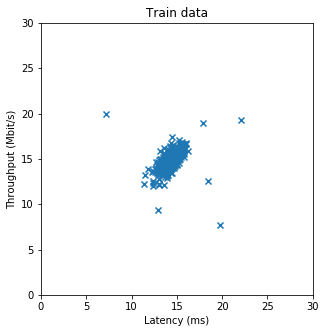

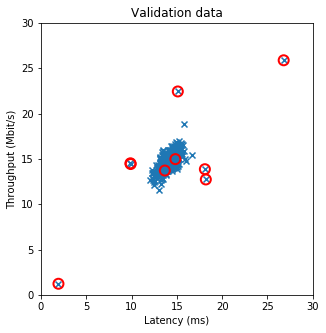

In [2]:
data = loadmat('data/anomaly1.mat')
X = data['X']
X_val, y_val = data['Xval'], data['yval'][:, 0]
plt.title('Train data')
plot_data(X)
plt.title('Validation data')
plot_data(X_val, y_val)

Utilize um modelo gaussiano multivariável para ajustar o conjunto de treinamento, i.e., estime a média e a matriz de covariância dos dados. Trace curvas de nível da densidade de probabilidade usando a função `plot_data(X, None, mean, cov)`. Para estimar a média e covariância, utilize as funções `np.mean()` e `np.cov()` (configure corretamente a orientação dos eixos).

Para fins de comparação, realize também uma estimação da matriz de covariância sob a hipótese de independência, i.e., estime a variância de cada dimensão independentemente e utilize esses valores para produzir uma matriz de covariância diagonal. Para isso, utilize a função `np.var()`. Qual estimação parece mais adequada? Por quê?

In [4]:
from sklearn import preprocessing

X_norm = sklearn.preprocessing.StandardScaler().fit_transform(X)
mean = np.mean(X_norm, axis = 0)
cov = np.cov(X_norm, rowvar = False)
model_gauss = multivariate_normal(mean,cov)

NameError: name 'sklearn' is not defined

Para realizar a detecção de anomalias, é necessário definir um limiar $\epsilon$ de tal forma que uma amostra $\bx$ é classificada como anômala quando $p(\bx) < \epsilon$. Não há um valor correto ou uma forma única de escolher este limiar; em última análise, trata-se de uma escolha arbitrária e que depende do modelo. Caso esteja disponível um conjunto de validação, uma forma objetiva de escolher o limiar é escolher aquele que maximiza uma métrica de classificação sobre o conjunto de validação. Naturalmente, a métrica deve ser robusta ao desbalanceamento do conjunto.

Inicialmente, escolha alguns valores de $\epsilon$, realize a predição no conjunto de **treinamento** e marque as anomalias no gráfico usando a função `plot_data(X, y_pred, mean, cov)`.

Em seguida, implemente uma função `select_threshold(p, y)` que tem como entrada um vetor `p` de probabilidades das amostras (estimadas segundo o modelo ajustado) e um vetor `y` com seus respectivos rótulos, e que retorna o valor de $\epsilon$ que maximiza o score F1 no conjunto fornecido, bem como o valor de F1 obtido. Utilize essa função no conjunto de **validação** para determinar $\epsilon$ e F1. Com este valor de limiar, realize a predição no conjunto de **treinamento** e novamente marque as anomalias no gráfico.

### Dicas de implementação

- Utilize a função `scipy.stats.multivariate_normal(mean, cov)` para definir o modelo e o respectivo método `.pdf()` para calcular a densidade de probabilidade.
- Utilize a função `sklearn.metrics.f1_score` para calcular o score F1.



In [3]:
print('epsilon =', epsilon)
print('F1 =', F1)

NameError: name 'epsilon' is not defined

Agora, realize a detecção de anomalias utilizando a função `sklearn.covariance.EllipticEnvelope` e compare os resultados obtidos. Esta função assume o mesmo modelo probabilístico, porém com duas diferenças:
- A estimação de variância é robusta a outliers;
- A predição é feita usando um valor de $\epsilon$ calculado automaticamente de tal forma a obter uma determinada fração de outliers, dada pelo parâmetro `contamination`.

Além disso, a predição considera a codificação -1 para representar uma amostra anômala e 1 para uma amostra normal.
Os parâmetros estimados pelo modelo (para uso pela função `plot_data`) ficam armazenados em `.location_` e `.covariance_`.

## Conjunto de dados #2

O próximo conjunto de dados possui $n=11$ atributos e um maior número de amostras de treinamento. Para uma maior variabilidade, também é feita uma transformação linear aleatória do espaço (correspondendo a rotações, reflexões e escalonamentos) através de uma matriz $\bT$.

Repita os itens anteriores comparando os 3 tipos de modelo gaussiano:
- Estimação de covariância completa;
- Estimação de covariância diagonal;
- Modelo EllipticEnvelope() do sklearn.

Desta vez não será possível visualizar a densidade de probabilidade em um espaço 11-dimensional, mas o score F1 no conjunto de validação pode ser calculado. Determine também o número de anomalias encontradas (no conjunto de treinamento) em cada modelo.

Em particular, na comparação com o método de estimação da covariância diagonal, experimente utilizar vários estados diferentes do gerador de números aleatórios. O que você observa? Explique.

In [9]:
data = loadmat('data/anomaly2.mat')
X = data['X']
X_val, y_val = data['Xval'], data['yval'][:, 0]
n = X.shape[1]
T = np.random.RandomState(0).randn(n,n)
X = X @ T
X_val = X_val @ T
print(X.shape, X_val.shape)

(1000, 11) (100, 11)


In [10]:
X_norm = sklearn.preprocessing.StandardScaler().fit_transform(X)
mean = np.mean(X_norm, axis = 0)
cov = np.cov(X_norm, rowvar = False)
model_gauss = multivariate_normal(mean,cov)

## Conjunto de dados #3

O próximo conjunto consiste de dados de transações de cartão de crédito, disponível em:

https://www.kaggle.com/mlg-ulb/creditcardfraud

O objetivo é identificar transações fradulentas. Os atributos consistem do rótulo da transação ($y=1$ corresponde a uma transação fradulenta) e 30 atributos de entrada, sendo que destes 28 correspondem às componentes principais dos atributos originais, os quais não são fornecidos por uma questão de confidencialidade. (Incidentalmente, este conjunto ilustra mais uma aplicação de PCA: anonimização.)

O conjunto é formado por 284807 amostras, sendo destas 492 fradulentas (anômalas). Separe 2/3 das amostras normais como conjunto de treinamento, e como conjunto de validação utilize todas as amostras anômalas e as restantes 1/3 de amostras normais, conforme proposto em:

https://www.dataversity.net/fraud-detection-using-a-neural-autoencoder/

O treinamento deve ser feito usando exclusivamente o conjunto de treinamento, enquanto o conjunto de validação deve ser usado para selecionar o limiar de classificação que maximiza o score F1.

Primeiramente, treine um modelo gaussiano, que servirá como baseline de comparação.

Em seguida, desenvolva um modelo usando uma rede autoencoder (utilizando Keras), com desempenho superior ao modelo gaussiano. Fique à vontade para utilizar múltiplas camadas e funções de ativação.

Para desenvolver e testar a rede autoencoder, separe como conjunto de teste (ou, mais precisamente, validação dessa etapa) uma fração de 10% do conjunto de treinamento, conforme proposto no link acima.

Reporte os resultados obtidos. Comente.

### Dicas
- Pode ser útil normalizar os dados.
- Experimente também excluir atributos.

In [13]:
import pandas as pd
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
X = data.to_numpy()[:,:-1]
y = data.to_numpy()[:,-1]

print(X.shape, y.shape)

(284807, 30) (284807,)


In [15]:
X_norm = sklearn.preprocessing.StandardScaler().fit_transform(X)
mean = np.mean(X_norm, axis = 0)
cov = np.cov(X_norm, rowvar = False)
model_gauss = multivariate_normal(mean,cov)

# Sistemas de recomendação

Leia os 3 últimos slides da Aula 9 (adicionados após a aula) para compreender a operação de **_embedding_**.

Para ilustrar a utilização com Keras, observe o exemplo abaixo (conjunto de dados retirado dos slides).

In [12]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam

n_users = 4
n_items = 5
n_factors = 2

data = np.array([[0,0,0],
                 [0,1,0],
                 [0,3,4],
                 [1,0,5],
                 [1,1,5],
                 [1,3,0],
                 [1,4,0],
                 [2,0,5],
                 [2,2,4],
                 [2,3,0],
                 [2,4,0],
                 [3,0,0],
                 [3,2,0],
                 [3,3,5],
                 [3,4,5]])

x = [data[:,0], data[:,1]] # list of length 2, corresponding to 2 inputs
y = data[:,2]

input_1 = Input(shape=(1,))
latent_1 = Embedding(n_users, n_factors)(input_1)
latent_1 = Reshape((n_factors,))(latent_1)

input_2 = Input(shape=(1,))
latent_2 = Embedding(n_items, n_factors)(input_2)
latent_2 = Reshape((n_factors,))(latent_2)

output = Dot(axes=1)([latent_1, latent_2])

model = Model(inputs=[input_1, input_2], outputs=output)

model.summary()

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         8           input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 2)         10          input_2[0][0]                    
____________________________________________________________________________________________

In [3]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.1))
model.fit(x=x, y=y, epochs=80)




Epoch 1/80
15/15 [==============================] - 0s 6ms/step - loss: 10.4692
Epoch 2/80
15/15 [==============================] - 0s 66us/step - loss: 10.4484
Epoch 3/80
15/15 [==============================] - 0s 66us/step - loss: 10.3305
Epoch 4/80
15/15 [==============================] - 0s 66us/step - loss: 10.1591
Epoch 5/80
15/15 [==============================] - 0s 32us/step - loss: 9.9110
Epoch 6/80
15/15 [==============================] - 0s 99us/step - loss: 9.5594
Epoch 7/80
15/15 [==============================] - 0s 66us/step - loss: 9.1013
Epoch 8/80
15/15 [==============================] - 0s 99us/step - loss: 8.5425
Epoch 9/80
15/15 [==============================] - 0s 66us/step - loss: 7.9005
Epoch 10/80
15/15 [==============================] - 0s 99us/step - loss: 7.2067
Epoch 11/80
15/15 [==============================] - 0s 66us/step - loss: 6.5115
Epoch 12/80
15/15 [==============================] - 0s 33us/step - loss: 5.8699
Epoch 13/80
15/15 [============

In [4]:
# Would Alice enjoy X-Men?
print(model.predict([np.array([0]),np.array([2])]))

# Would Alice enjoy Pretty Woman?
print(model.predict([np.array([0]),np.array([4])]))

[[0.08145317]]
[[4.0695596]]


## Conjunto de dados #4

Baseado no exemplo acima, desenvolva um modelo de predição para o conjunto de dados [MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/100k/), o qual consiste de 100000 avaliações de filmes em uma escala de 1 a 5, feitas por 943 usuários sobre 1682 filmes. Certifique-se de separar o conjunto em treinamento e teste, para posteriormente testar suas predições.

(OPCIONAL) Para melhorar o desempenho do modelo, introduza *biases* de usuários e de filmes, e possivelmente mais camadas ocultas, conforme exemplo em:

https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929